##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Basic training loops

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/basic_training_loops"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/basic_training_loops.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/guide/basic_training_loops.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/basic_training_loops.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In the previous guides, you have learned about [tensors](./tensor.ipynb), [variables](./variable.ipynb), [gradient tape](autodiff.ipynb), and [modules](./intro_to_modules.ipynb).  In this guide, you will fit these all together to train models.

TensorFlow also includes the [tf.Keras API](https://www.tensorflow.org/guide/keras/overview), a high-level neural network API that provides useful abstractions to reduce boilerplate.  However, in this guide, you will use basic classes.

## Setup

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Solving machine learning problems

Solving a machine learning problem usually consists of the following steps:

 - Obtain training data.
 - Define the model.
 - Define a loss function.
 - Run through the training data, calculating loss from the ideal value
 - Calculate gradients for that loss and use an *optimizer* to adjust the variables to fit the data.
 - Evaluate your results.

For illustration purposes, in this guide you'll develop a simple linear model, $f(x) = x * W + b$, which has two variables: $W$ (weights) and $b$ (bias).

This is the most basic of machine learning problems:  Given $x$ and $y$, try to find the slope and offset of a line via  [simple linear regression](https://en.wikipedia.org/wiki/Linear_regression#Simple_and_multiple_linear_regression).

머신러닝 문제 해결하기

머신러닝 문제의 해결은 일반적으로 다음 단계로 구성됩니다.

- 훈련 데이터를 얻습니다.
- 모델을 정의합니다.
- 손실 함수를 정의합니다.
- 훈련 데이터를 실행하여 이상적인 값에서 손실을 계산합니다.
- 손실에 대한 기울기를 계산하고 *최적화 프로그램* 를 사용하여 데이터에 맞게 변수를 조정합니다.
- 결과를 평가합니다.

설명을 위해 이 가이드에서는 $W$(가중치) 및 $b$(바이어스)의 두 가지 변수가 있는 간단한 선형 모델 $f(x) = x * W + b$를 개발합니다.

이것이 가장 기본적인 머신러닝 문제입니다. $x$와 $y$가 주어지면 [간단한 선형 회귀](https://en.wikipedia.org/wiki/Linear_regression#Simple_and_multiple_linear_regression)를 통해 선의 기울기와 오프셋을 찾습니다.

## Data

Supervised learning uses *inputs* (usually denoted as *x*) and *outputs* (denoted *y*, often called *labels*).  The goal is to learn from paired inputs and outputs so that you can predict the value of an output from an input.

Each input of your data, in TensorFlow, is almost always represented by a tensor, and is often a vector. In supervised training, the output (or value you'd like to predict) is also a tensor.

Here is some data synthesized by adding Gaussian (Normal) noise to points along a line.

지도 학습은 *입력*(일반적으로 *x*로 표시됨)과 *출력*(*y*로 표시, 종종 *레이블*이라고 함)을 사용합니다. 목표는 입력에서 출력 값을 예측할 수 있도록 쌍을 이룬 입력과 출력에서 학습하는 것입니다.

TensorFlow에서 데이터의 각 입력은 거의 항상 텐서로 표현되며, 종종 벡터입니다. 지도 학습에서 출력(또는 예측하려는 값)도 텐서입니다.

다음은 선을 따라 점에 가우시안 (정규 분포) 노이즈를 추가하여 합성된 데이터입니다.

In [ ]:
# The actual line
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 201

# A vector of random x values
x = tf.linspace(-2, 2, NUM_EXAMPLES)
x = tf.cast(x, tf.float32)

def f(x):
  return x * TRUE_W + TRUE_B

# Generate some noise
noise = tf.random.normal(shape=[NUM_EXAMPLES])

# Calculate y
y = f(x) + noise

In [2]:
# The actual line
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 201

# A vector of random x values
x = tf.linspace(-2, 2, NUM_EXAMPLES)
x = tf.cast(x, tf.float32)

def f(x):
  return x * TRUE_W + TRUE_B

# Generate some noise
noise = tf.random.normal(shape=[NUM_EXAMPLES])

# Calculate y
y = f(x) + noise

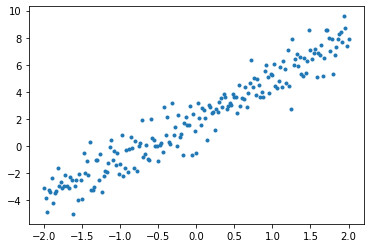

In [7]:
# Plot all the data
plt.plot(x, y, '.')
plt.show()

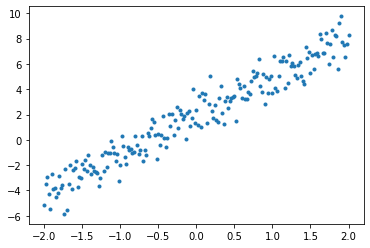

In [ ]:
# Plot all the data
plt.plot(x, y, '.')
plt.show()

Tensors are usually gathered together in *batches*, or groups of inputs and outputs stacked together.  Batching can confer some training benefits and works well with accelerators and vectorized computation.  Given how small this dataset is, you can treat the entire dataset as a single batch.

텐서는 일반적으로 *배치* 또는 입력과 출력이 함께 쌓인 그룹의 형태로 수집됩니다. 일괄 처리는 몇 가지 훈련 이점을 제공할 수 있으며 가속기 및 벡터화된 계산에서 잘 동작합니다. 데이터세트가 얼마나 작은지를 고려할 때 전체 데이터세트를 단일 배치로 처리할 수 있습니다.

## Define the model

Use `tf.Variable` to represent all weights in a model.  A `tf.Variable` stores a value and provides this in tensor form as needed.  See the [variable guide](./variable.ipynb) for more details.

Use `tf.Module` to encapsulate the variables and the computation.  You could use any Python object, but this way it can be easily saved.

Here, you define both *w* and *b* as variables.

모델 정의하기

`tf.Variable`을 사용하여 모델의 모든 가중치를 나타냅니다. `tf.Variable`은 값을 저장하고 필요에 따라 텐서 형식으로 제공합니다. 자세한 내용은 [변수 가이드](./variable.ipynb)를 참조하세요.

`tf.Module`을 사용하여 변수와 계산을 캡슐화합니다. 모든 Python 객체를 사용할 수 있지만 이렇게 하면 쉽게 저장할 수 있습니다.

여기서 *w*와 *b*를 모두 변수로 정의합니다.

In [ ]:
class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x):
    return self.w * x + self.b

In [ ]:
model = MyModel()

# List the variables tf.modules's built-in variable aggregation.
print("Variables:", model.variables)

# Verify the model works
assert model(3.0).numpy() == 15.0

Variables: (<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.0>)


The initial variables are set here in a fixed way, but Keras comes with any of a number of [initializers](https://www.tensorflow.org/api_docs/python/tf/keras/initializers) you could use, with or without the rest of Keras.

초기 변수는 여기에서 고정된 방식으로 설정되지만 Keras에는 나머지 Keras의 유무에 관계없이 사용할 수 있는 여러 [초기화 프로그램](https://www.tensorflow.org/api_docs/python/tf/keras/initializers)이 함께 제공됩니다.

### Define a loss function

A loss function measures how well the output of a model for a given input matches the target output. The goal is to minimize this difference during training. Define the standard L2 loss, also known as the "mean squared" error:

손실 함수 정의하기

손실 함수는 주어진 입력에 대한 모델의 출력이 목표 출력과 얼마나 잘 일치하는지 측정합니다. 목표는 훈련 중에 이러한 차이를 최소화하는 것입니다. "평균 제곱" 오류라고도 하는 표준 L2 손실을 정의합니다.

In [ ]:
# This computes a single loss value for an entire batch
def loss(target_y, predicted_y):
  return tf.reduce_mean(tf.square(target_y - predicted_y))

Before training the model, you can visualize the loss value by plotting the model's predictions in red and the training data in blue:

모델을 훈련하기 전에 모델의 예측을 빨간색으로, 훈련 데이터를 파란색으로 플롯하여 손실값을 시각화할 수 있습니다.

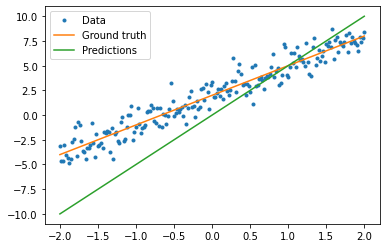

Current loss: 10.517460


In [ ]:
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label="Ground truth")
plt.plot(x, model(x), label="Predictions")
plt.legend()
plt.show()

print("Current loss: %1.6f" % loss(y, model(x)).numpy())

### Define a training loop

The training loop consists of repeatedly doing three tasks in order:

* Sending a batch of inputs through the model to generate outputs
* Calculating the loss by comparing the outputs to the output (or label)
* Using gradient tape to find the gradients
* Optimizing the variables with those gradients

For this example, you can train the model using [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent).

There are many variants of the gradient descent scheme that are captured in `tf.keras.optimizers`. But in the spirit of building from first principles, here you will implement the basic math yourself with the help of `tf.GradientTape` for automatic differentiation and `tf.assign_sub` for decrementing a value (which combines `tf.assign` and `tf.sub`):

훈련 루프 정의하기

훈련 루프는 순서대로 3가지 작업을 반복적으로 수행하는 것으로 구성됩니다.

- 모델을 통해 입력 배치를 전송하여 출력 생성
- 출력을 출력(또는 레이블)과 비교하여 손실 계산
- 그래디언트 테이프를 사용하여 그래디언트 찾기
- 해당 그래디언트로 변수 최적화

이 예제에서는 [경사 하강법](https://en.wikipedia.org/wiki/Gradient_descent)을 사용하여 모델을 훈련할 수 있습니다.

`tf.keras.optimizers`에서 캡처되는 경사 하강법 체계에는 다양한 변형이 있습니다. 하지만 첫 번째 원칙을 준수하는 의미에서, 기본적인 수학을 직접 구현할 것입니다. 자동 미분을 위한 `tf.GradientTape` 및 값 감소를 위한 `tf.assign_sub`(`tf.assign`과 `tf.sub`를 결합하는 값)의 도움을 받습니다.

In [ ]:
# Given a callable model, inputs, outputs, and a learning rate...
def train(model, x, y, learning_rate):

  with tf.GradientTape() as t:
    # Trainable variables are automatically tracked by GradientTape
    current_loss = loss(y, model(x))

  # Use GradientTape to calculate the gradients with respect to W and b
  dw, db = t.gradient(current_loss, [model.w, model.b])

  # Subtract the gradient scaled by the learning rate
  model.w.assign_sub(learning_rate * dw)
  model.b.assign_sub(learning_rate * db)

For a look at training, you can send the same batch of *x* and *y* through the training loop, and see how `W` and `b` evolve.

훈련을 살펴보려면 훈련 루프를 통해 *x* 및 *y*의 같은 배치를 보내고 `W` 및 `b`가 발전하는 모양을 확인합니다.

In [ ]:
model = MyModel()

# Collect the history of W-values and b-values to plot later
weights = []
biases = []
epochs = range(10)

# Define a training loop
def report(model, loss):
  return f"W = {model.w.numpy():1.2f}, b = {model.b.numpy():1.2f}, loss={loss:2.5f}"


def training_loop(model, x, y):

  for epoch in epochs:
    # Update the model with the single giant batch
    train(model, x, y, learning_rate=0.1)

    # Track this before I update
    weights.append(model.w.numpy())
    biases.append(model.b.numpy())
    current_loss = loss(y, model(x))

    print(f"Epoch {epoch:2d}:")
    print("    ", report(model, current_loss))

Do the training

In [ ]:
current_loss = loss(y, model(x))

print(f"Starting:")
print("    ", report(model, current_loss))

Starting:
     W = 3.09, b = 1.81, loss=1.06483


In [ ]:
training_loop(model, x, y)

Epoch  0:
     W = 3.00, b = 2.01, loss=1.00750
Epoch  1:
     W = 3.00, b = 2.02, loss=1.00737
Epoch  2:
     W = 3.00, b = 2.02, loss=1.00728
Epoch  3:
     W = 3.00, b = 2.02, loss=1.00723
Epoch  4:
     W = 3.00, b = 2.02, loss=1.00719
Epoch  5:
     W = 3.00, b = 2.03, loss=1.00717
Epoch  6:
     W = 3.00, b = 2.03, loss=1.00716
Epoch  7:
     W = 3.00, b = 2.03, loss=1.00715
Epoch  8:
     W = 3.00, b = 2.03, loss=1.00714
Epoch  9:
     W = 3.00, b = 2.03, loss=1.00714


Plot the evolution of the weights over time:

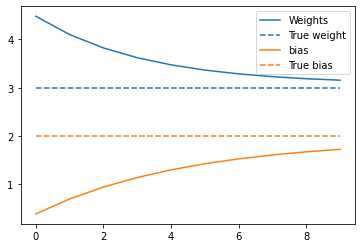

In [ ]:
plt.plot(epochs, weights, label='Weights', color=colors[0])
plt.plot(epochs, [TRUE_W] * len(epochs), '--',
         label = "True weight", color=colors[0])

plt.plot(epochs, biases, label='bias', color=colors[1])
plt.plot(epochs, [TRUE_B] * len(epochs), "--",
         label="True bias", color=colors[1])

plt.legend()
plt.show()

Visualize how the trained model performs

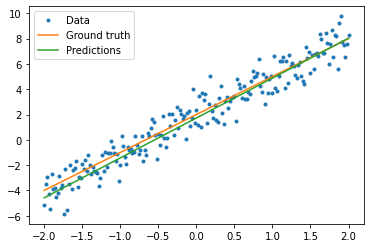

Current loss: 0.950985


In [ ]:
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label="Ground truth")             # Ground truth : lable이라함
plt.plot(x, model(x), label="Predictions")
plt.legend()
plt.show()

print("Current loss: %1.6f" % loss(model(x), y).numpy())

## The same solution, but with Keras

It's useful to contrast the code above with the equivalent in Keras.

Defining the model looks exactly the same if you subclass `tf.keras.Model`.  Remember that Keras models inherit ultimately from module.

위의 코드를 Keras의 해당 코드와 대조해 보면 유용합니다.

`tf.keras.Model`을 하위 클래스화하면 모델 정의는 정확히 같게 보입니다. Keras 모델은 궁극적으로 모듈에서 상속한다는 것을 기억하세요.

In [ ]:
class MyModelKeras(tf.keras.Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def call(self, x):
    return self.w * x + self.b

keras_model = MyModelKeras()

# Reuse the training loop with a Keras model
training_loop(keras_model, x, y)

# You can also save a checkpoint using Keras's built-in support
keras_model.save_weights("my_checkpoint")

Epoch  0:
     W = 4.46, b = 0.41, loss=6.52232
Epoch  1:
     W = 4.07, b = 0.73, loss=4.23178
Epoch  2:
     W = 3.78, b = 0.99, loss=2.90804
Epoch  3:
     W = 3.57, b = 1.20, loss=2.13676
Epoch  4:
     W = 3.42, b = 1.37, loss=1.68368
Epoch  5:
     W = 3.30, b = 1.50, loss=1.41534
Epoch  6:
     W = 3.22, b = 1.61, loss=1.25515
Epoch  7:
     W = 3.16, b = 1.69, loss=1.15880
Epoch  8:
     W = 3.12, b = 1.76, loss=1.10043
Epoch  9:
     W = 3.09, b = 1.81, loss=1.06483


Rather than write new training loops each time you create a model, you can use the built-in features of Keras as a shortcut.  This can be useful when you do not want to write or debug Python training loops.

If you do, you will need to use `model.compile()` to set the parameters, and `model.fit()` to train.  It can be less code to use Keras implementations of L2 loss and gradient descent, again as a shortcut.  Keras losses and optimizers can be used outside of these convenience functions, too, and the previous example could have used them.

모델을 생성할 때마다 새로운 훈련 루프를 작성하는 대신 Keras의 내장 기능을 바로 가기로 사용할 수 있습니다. Python 훈련 루프를 작성하거나 디버그하지 않으려는 경우 유용할 수 있습니다.

그렇게 하려면, `model.compile()`을 사용하여 매개변수를 설정하고 `model.fit()`을 사용하여 훈련해야 합니다. L2 손실 및 경사 하강법의 Keras 구현을 바로 가기로 사용하면 코드가 적을 수 있습니다. Keras 손실 및 최적화 프록그램은 이러한 편의성 함수 외부에서 사용할 수 있으며 이전 예제에서 사용할 수 있습니다.

In [ ]:
keras_model = MyModelKeras()

# compile sets the training parameters
keras_model.compile(
    # By default, fit() uses tf.function().  You can
    # turn that off for debugging, but it is on now.
    run_eagerly=False,

    # Using a built-in optimizer, configuring as an object
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),

    # Keras comes with built-in MSE error
    # However, you could use the loss function
    # defined above
    loss=tf.keras.losses.mean_squared_error,
)

Keras `fit` expects batched data or a complete dataset as a NumPy array.  NumPy arrays are chopped into batches and default to a batch size of 32.

In this case, to match the behavior of the hand-written loop, you should pass `x` in as a single batch of size 1000.

Keras `fit` 배치 데이터 또는 전체 데이터세트를 NumPy 배열로 예상합니다. NumPy 배열은 배치로 분할되며, 기본 배치 크기는 32입니다.

이 경우 손으로 쓴 루프의 동작과 일치시키려면 `x`를 크기 1000의 단일 배치로 전달해야 합니다.

In [ ]:
print(x.shape[0])
keras_model.fit(x, y, epochs=10, batch_size=1000)     # batch_size = 201로 해도 동일
# keras_model.fit(x, y, epochs=100)                   # batch_size = 32, 201

201
Epoch 1/10
3/3 [==============================] - 0s 7ms/step - loss: 1.0610
Epoch 2/10
3/3 [==============================] - 0s 6ms/step - loss: 1.0248
Epoch 3/10
3/3 [==============================] - 0s 6ms/step - loss: 1.0231
Epoch 4/10
3/3 [==============================] - 0s 6ms/step - loss: 2.0296
Epoch 5/10
3/3 [==============================] - 0s 6ms/step - loss: 1.9255
Epoch 6/10
3/3 [==============================] - 0s 5ms/step - loss: 1.2747
Epoch 7/10
3/3 [==============================] - 0s 7ms/step - loss: 1.1722
Epoch 8/10
3/3 [==============================] - 0s 7ms/step - loss: 1.0145
Epoch 9/10
3/3 [==============================] - 0s 5ms/step - loss: 1.0215
Epoch 10/10
3/3 [==============================] - 0s 12ms/step - loss: 1.0284


Note that Keras prints out the loss after training, not before, so the first loss appears lower, but otherwise this shows essentially the same training performance.

Keras는 훈련 전이 아닌 훈련 후 손실을 출력하므로 첫 번째 손실이 더 낮게 나타나지만, 그렇지 않으면 본질적으로 같은 훈련 성능을 보여줍니다.

## Next steps

In this guide, you have seen how to use the core classes of tensors, variables, modules, and gradient tape to build and train a model, and further how those ideas map to Keras.

This is, however, an extremely simple problem. For a more practical introduction, see [Custom training walkthrough](../tutorials/customization/custom_training_walkthrough.ipynb).

For more on using built-in Keras training loops, see [this guide](https://www.tensorflow.org/guide/keras/train_and_evaluate).  For more on training loops and Keras, see [this guide](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch).  For writing custom distributed training loops, see [this guide](distributed_training.ipynb#using_tfdistributestrategy_with_basic_training_loops_loops).

이 가이드에서는 텐서, 변수, 모듈 및 그래디언트 테이프의 핵심 클래스를 사용하여 모델을 빌드하고 훈련하는 방법과 이러한 아이디어가 Keras에 매핑되는 방법을 살펴보았습니다.

그러나 이것은 매우 단순한 문제입니다. 보다 실용적인 소개는 [사용자 정의 훈련 연습](../tutorials/customization/custom_training_walkthrough.ipynb)을 참조하세요.

내장 Keras 훈련 루프의 사용에 관한 자세한 내용은 [이 가이드](https://www.tensorflow.org/guide/keras/train_and_evaluate)를 참조하세요. 훈련 루프 및 Keras에 관한 자세한 내용은 [이 가이드](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)를 참조하세요. 사용자 정의 분산 훈련 루프의 작성에 관해서는 [이 가이드](distributed_training.ipynb#using_tfdistributestrategy_with_basic_training_loops_loops)를 참조하세요.